## **1. ARIMA Model**

## **Steps:**

- Importing Libraries and Loading the Data
- Plotting the time series to identify trends, seasonality, stationarity..
- Training the Model **auto-arima; finding best parameters(p,d,q)**
- Interpreting model's summary
- Splitting the data (80 - 20 split)
- Training **ARIMA** model with best parameters
- Testing and reporting **MAPE**
- Short-term and long-term term prediction on entire data
- Visualizing the short-term and long-term prediction
- Writing the prediction into csv file and averaging them along with MAPE



In [49]:
!pip install pmdarima
!pip install arch

In [50]:
%cd /content/drive/MyDrive/FP-2

/content/drive/MyDrive/FP-2


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading the data**

In [52]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from arch import arch_model

In [53]:
# Loading the Data
data = pd.read_csv('stock_prc_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.asfreq('B')  # Setting frequency to business days
data = data.fillna(method='ffill')  # Forward fill missing values(if any)

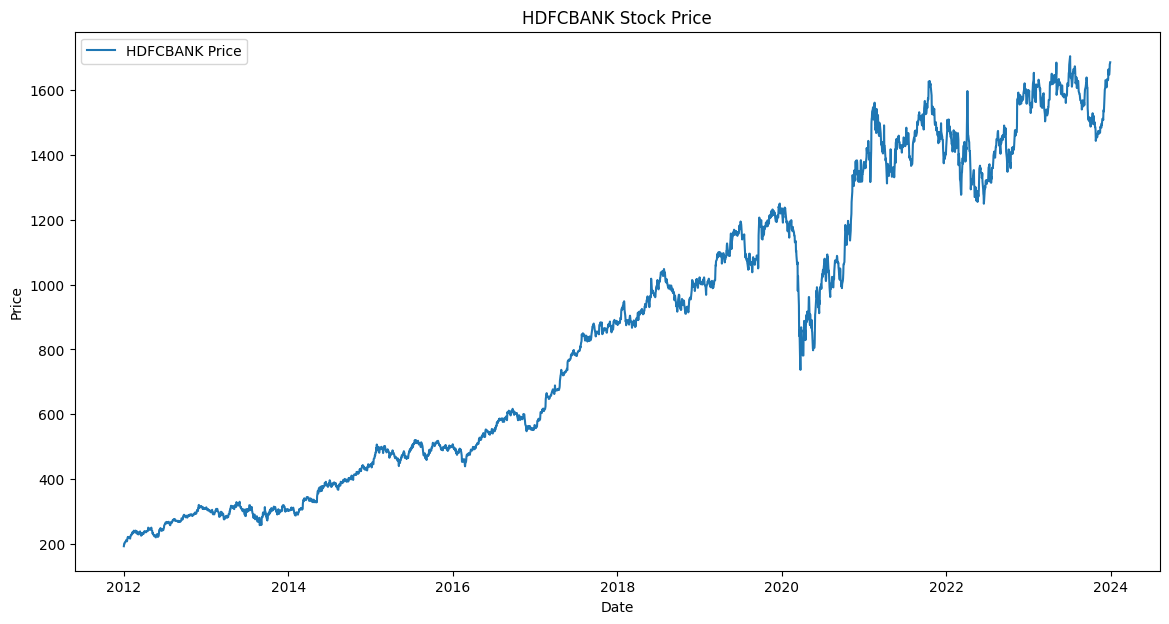

In [54]:
# Plotting the time series to identify trends, seasonality, stationarity
plt.figure(figsize=(14, 7))
plt.plot(data['HDFCBANK'], label='HDFCBANK Price')
plt.title('HDFCBANK Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Trend:** *This graph shows a clear upward trend over time. This suggests that HDFCBANK’s stock price has generally increased from around 2012 to 2024.*

**Seasonality:** *Unfortunately, the graph’s long-term view doesn’t reveal obvious seasonal patterns. To identify seasonality, we’d need more granular data (e.g., daily or monthly prices). Seasonal effects might exist, but they’re not immediately evident here.*

**Stationarity:** *A stationary time series maintains consistent statistical properties (mean, variance) over time. In this graph, the upward trend indicates non-stationarity. Additionally, we will run few test to check its stationarity.*

.

### **Stationarity**

- Checking Stationarity using Augmented Dickey-Fuller (ADF) test of the time series before training the auto-ARIMA model. If the series is non-stationary, we'll differentiate it accordingly before proceeding(make it stationary).

In [55]:
# Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(data['HDFCBANK'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t{}: {:.3f}'.format(key, value))

ADF Statistic: -0.3815028255467945
p-value: 0.913141635756759
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


ADF test result indicates that the ADF statistic (-0.38) is higher than the critical values at 1%, 5%, and 10% significance levels, and the p-value (0.913) is greater than 0.05. This suggests that the time series is non-stationary.Therefore, differencing is required to achieve stationarity before fitting the ARIMA model.

In [56]:
# Differencing the series for making it stationary
if adf_result[1] > 0.05:
    data_diff = data['HDFCBANK'].diff().dropna()
    adf_result_diff = adfuller(data_diff)
    print('ADF Statistic (Differenced):', adf_result_diff[0])
    print('p-value (Differenced):', adf_result_diff[1])
    print('Critical Values (Differenced):')
    for key, value in adf_result_diff[4].items():
        print('\t{}: {:.3f}'.format(key, value))
else:
    data_diff = data['HDFCBANK']

ADF Statistic (Differenced): -24.33383531289398
p-value (Differenced): 0.0
Critical Values (Differenced):
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **Auto-ARIMA; finding best-parameters(p,d,q)**

In [57]:
# Training the Model auto-arima; finding best parameters(p,d,q)
model_arima = auto_arima(data_diff, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(data_diff)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=25213.374, Time=3.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25240.342, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25238.332, Time=0.74 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25237.902, Time=1.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=25233.168, Time=4.71 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=25232.381, Time=3.52 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=9.86 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=25214.717, Time=7.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25238.110, Time=2.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=25229.796, Time=2.95 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=25229.624, Time=2.72 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=25216.678, Time=9.46 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25211.381, Time=10.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=25230.909, Time=3.98 sec
 ARIMA(2,0,1)(0,0,0)[0] 

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [58]:
# Interpreting model's summary
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3129
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -12599.691
Date:                Thu, 11 Jul 2024   AIC                          25211.381
Time:                        05:56:51   BIC                          25247.672
Sample:                    01-03-2012   HQIC                         25224.407
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8052      0.405      1.988      0.047       0.011       1.599
ar.L1          0.1361      0.045      2.995      0.003       0.047       0.225
ar.L2         -0.8202      0.037    -22.249      0.0

### **Interpretation of model's summary**

#### **Model Parameters:**

**intercept: 0.8052 (std err: 0.405, p-value: 0.047)**

*This is the constant term in the model, significant at the 5% level (p-value < 0.05).*

**ar.L1: 0.1361 (std err: 0.045, p-value: 0.003)**

*Coefficient for the first lag of the autoregressive term, significant at the 1% level.*

**ar.L2: -0.8202 (std err: 0.037, p-value: 0.000)**

*Coefficient for the second lag of the autoregressive term, highly significant (p-value < 0.01).*

**ma.L1: -0.1062 (std err: 0.050, p-value: 0.032)**

*Coefficient for the first lag of the moving average term, significant at the 5% level.*

**ma.L2: 0.7651 (std err: 0.042, p-value: 0.000)**

*Coefficient for the second lag of the moving average term, highly significant (p-value < 0.01).*

**sigma2: 184.1261 (std err: 1.747, p-value: 0.000)**

*The variance of the error term, highly significant.*

#### **Model Fit Statistics:**

**Log Likelihood: -12599.691**

*Indicates the goodness-of-fit of the model; higher values are better.*

**AIC (Akaike Information Criterion): 25211.381**

*Used for model selection; lower values indicate a better model.*

**BIC (Bayesian Information Criterion): 25247.672**

*Similar to AIC but includes a penalty for the number of parameters; lower values are better.*


**Ljung-Box (L1) (Q): 0.09 (Prob(Q): 0.76)**

*Tests for autocorrelation in the residuals; a high p-value (> 0.05) indicates no significant autocorrelation.*


.

### **Train & Test Split**
### **Training, Testing and Reporting MAPE**

In [59]:
# Splitting the data (80 - 20 split)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test))
mape = mean_absolute_percentage_error(test, forecast)
print(f'MAPE: {mape}')

MAPE: 0.08257095101761536


### **Training ARIMA on the entire dataset and forecasting**

#### **Short-term & Long-term forecast**

In [60]:
# Train ARIMA model on the entire dataset
model = ARIMA(data['HDFCBANK'], order=(2,0,2))
model_fit = model.fit()

# Short-term prediction (next 120 days)
short_term_forecast = model_fit.forecast(steps=120)

# Long-term prediction (next 360 days)
long_term_forecast = model_fit.forecast(steps=360)

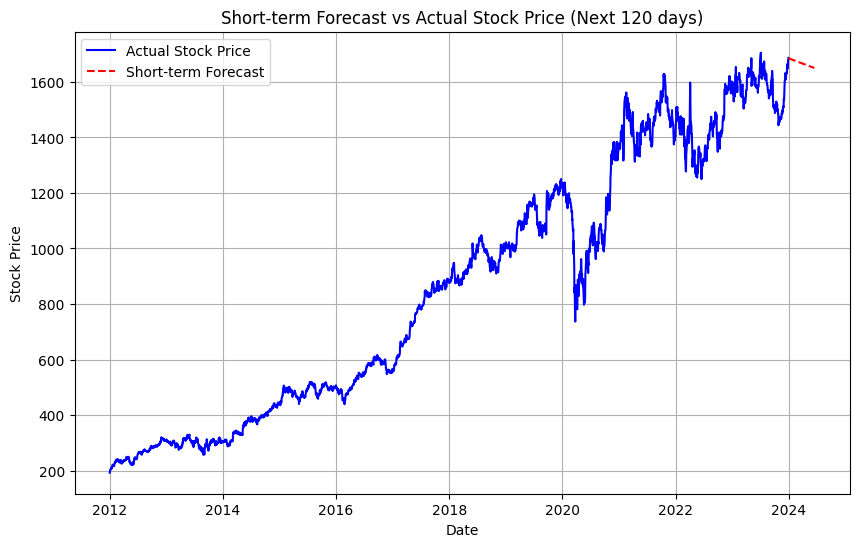

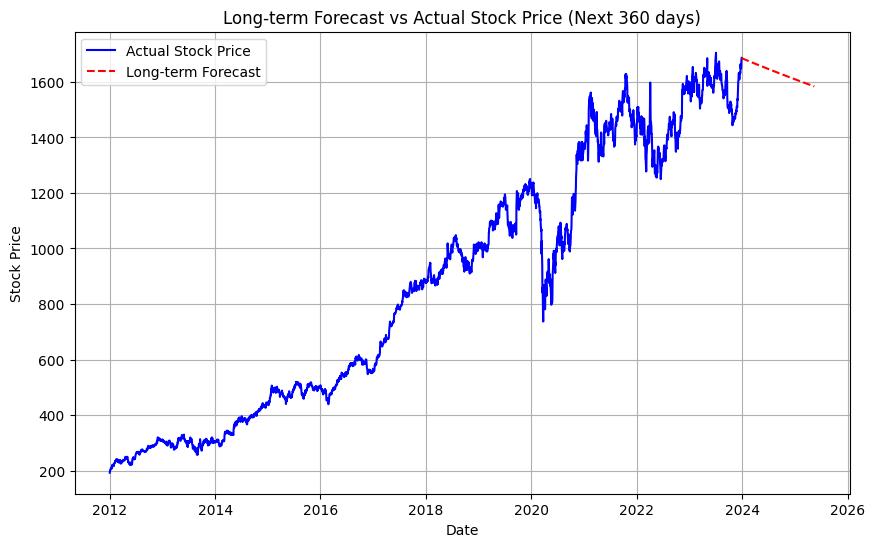

In [61]:
# Plotting short-term forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=120, freq='B'), short_term_forecast, label='Short-term Forecast', color='red', linestyle='--')
plt.title('Short-term Forecast vs Actual Stock Price (Next 120 days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plotting long-term forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=360, freq='B'), long_term_forecast, label='Long-term Forecast', color='red', linestyle='--')
plt.title('Long-term Forecast vs Actual Stock Price (Next 360 days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## **2. Holt's Linear Trend Model**

In [62]:
model_holt = ExponentialSmoothing(train['HDFCBANK'], trend='add')
model_fit_holt = model_holt.fit()

In [63]:
# Forecasting and Reporting MAPE
forecast_holt = model_fit_holt.forecast(steps=len(test))
forecast_holt = pd.Series(forecast_holt, index=test.index)
mape_holt = mean_absolute_percentage_error(test['HDFCBANK'], forecast_holt)
print(f'MAPE (Holt): {mape_holt}')

MAPE (Holt): 0.07299426571964895


- Holt's Linear Trend Model outperforms ARIMA

### **Training Holt Linear Trend model on the entire dataset and forecasting**

#### **Short-term & Long-term forecast**

In [64]:
# Train Holt Linear Trend model on the entire dataset
model_holt = ExponentialSmoothing(data['HDFCBANK'], trend='add')
model_fit_holt = model_holt.fit()
print(model_fit_holt.summary())

# Short-term prediction (next 120 days)
short_term_forecast_holt = model_fit_holt.forecast(steps=120)

# Long-term prediction (next 360 days)
long_term_forecast_holt = model_fit_holt.forecast(steps=360)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 HDFCBANK   No. Observations:                 3130
Model:             ExponentialSmoothing   SSE                         583360.690
Optimized:                         True   AIC                          16370.928
Trend:                         Additive   BIC                          16395.124
Seasonal:                          None   AICC                         16370.955
Seasonal Periods:                  None   Date:                 Thu, 11 Jul 2024
Box-Cox:                          False   Time:                         05:56:58
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950092                alpha                 True
smoothing_trend            0.00093

### **Interpretation of model's summary**

#### **Coefficients:**

**smoothing_level (alpha):** *This is the smoothing parameter for the level. A value close to 1 (0.9950092) suggests that the model gives more weight to the most recent observations.*

**smoothing_trend (beta):** *This is the smoothing parameter for the trend. A very small value (0.0009387) indicates that the trend component is almost constant over time.*

**initial_level (l.0):** *This is the initial level of the series (193.10055).*

**initial_trend (b.0):** *This is the initial trend of the series (0.3928855).*

**Dep. Variable:** *The dependent variable is HDFCBANK, which indicates that the model is predicting the stock prices of HDFC Bank.*

**No. Observations:** *The number of observations in the dataset is 3130.*

**Model:** *The model used is Exponential Smoothing with an additive trend and no seasonal component.*

**SSE (Sum of Squared Errors):** *This is the sum of the squared differences between the observed and fitted values. A lower SSE indicates a better fit. In this case, SSE is 583360.690.*

**AIC (Akaike Information Criterion):** *AIC is a measure of the relative quality of statistical models for a given dataset. A lower AIC value indicates a better model. Here, AIC is 16370.928.*

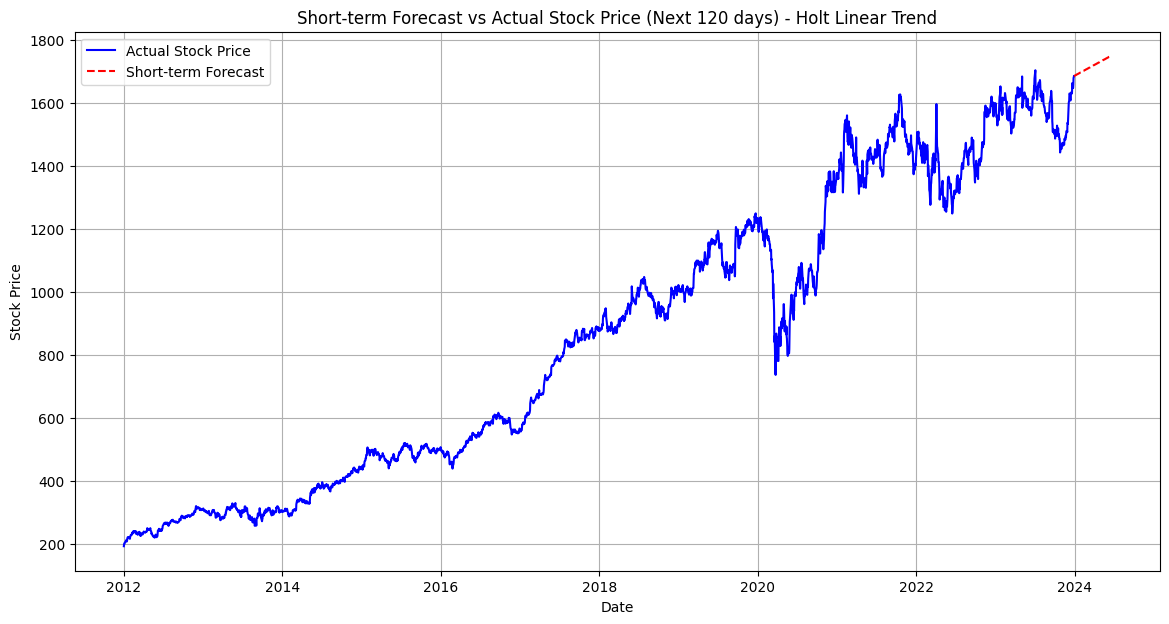

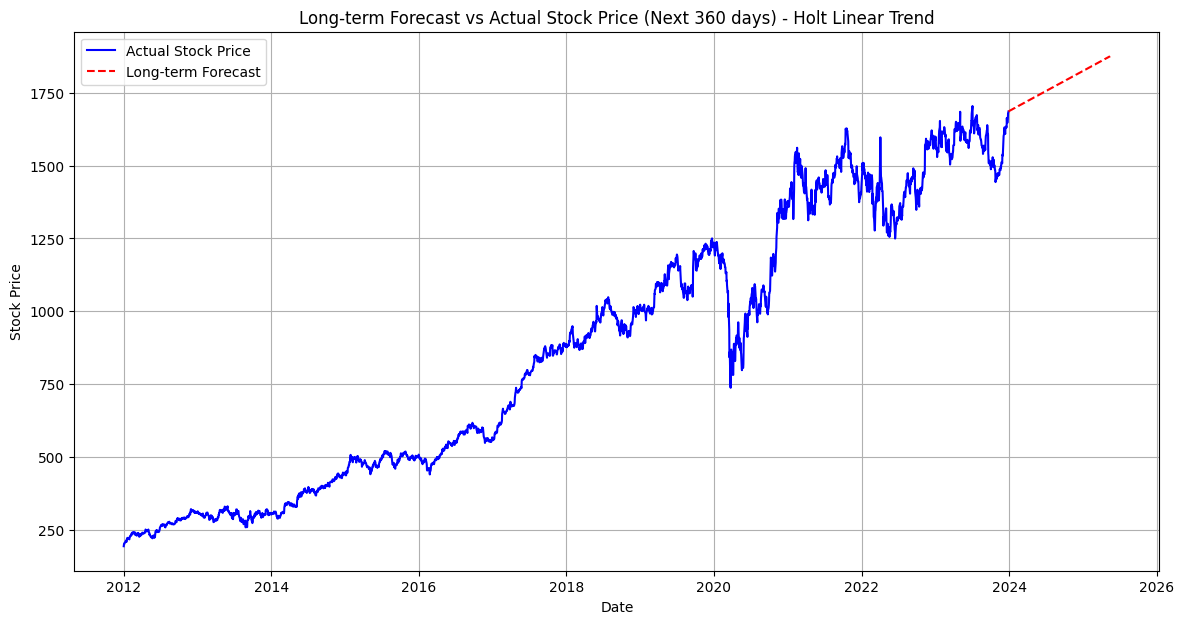

In [65]:
# Plotting short-term forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=120, freq='B'), short_term_forecast_holt, label='Short-term Forecast', color='red', linestyle='--')
plt.title('Short-term Forecast vs Actual Stock Price (Next 120 days) - Holt Linear Trend')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plotting long-term forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=360, freq='B'), long_term_forecast_holt, label='Long-term Forecast', color='red', linestyle='--')
plt.title('Long-term Forecast vs Actual Stock Price (Next 360 days) - Holt Linear Trend')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## **3. Holt-Winters' Seasonal Model**

In [69]:
model_hw = ExponentialSmoothing(train['HDFCBANK'], trend='add', seasonal='add', seasonal_periods=12)
model_fit_hw = model_hw.fit()

In [70]:
forecast_hw = model_fit_hw.forecast(steps=len(test))
forecast_hw = pd.Series(forecast_hw, index=test.index)
mape_hw = mean_absolute_percentage_error(test['HDFCBANK'], forecast_hw)
print(f'MAPE (Holt-Winters): {mape_hw}')

MAPE (Holt-Winters): 0.1052576586837949


- We don't see this model performing well compared to previous models.

### **Training Holt-Winter's Seasonal model on the entire dataset and forecasting**
#### **Short-term & Long-term forecast**

In [71]:
# Train Holt-Winters' Seasonal Model on the entire dataset
model_hw = ExponentialSmoothing(data['HDFCBANK'], trend='add', seasonal='add', seasonal_periods=12)
model_fit_hw = model_hw.fit()
print(model_fit_hw.summary())

# Short-term prediction (next 120 days)
short_term_forecast_hw = model_fit_hw.forecast(steps=120)

# Long-term prediction (next 360 days)
long_term_forecast_hw = model_fit_hw.forecast(steps=360)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 HDFCBANK   No. Observations:                 3130
Model:             ExponentialSmoothing   SSE                         585341.416
Optimized:                         True   AIC                          16405.538
Trend:                         Additive   BIC                          16502.319
Seasonal:                      Additive   AICC                         16405.758
Seasonal Periods:                    12   Date:                 Thu, 11 Jul 2024
Box-Cox:                          False   Time:                         06:03:49
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9923375                alpha                 True
smoothing_trend          

### **Interpretation of model's summary**

**AIC (Akaike Information Criterion):16405.538** - *This is a measure of the relative quality of the model. Lower AIC values suggest a better model.*

#### **Coefficients:**

**smoothing_level (alpha): 0.9923375** - *This indicates the smoothing parameter for the level component. A value close to 1 indicates that the model heavily weighs the most recent observations.*

**smoothing_trend (beta): 0.0013742** - *This indicates the smoothing parameter for the trend component. A very low value suggests that the trend component changes very slowly.*

**smoothing_seasonal (gamma): 0.0038218** - *This indicates the smoothing parameter for the seasonal component. A low value suggests that the seasonal component changes very slowly.*

**initial_level (l.0): 205.49755** - *This is the initial level of the series.*

**initial_trend (b.0): 0.0400259** - *This is the initial trend of the series.*

**initial_seasons (s.0 to s.11)** - *These are the initial seasonal components for each season within the period.*



***The initial seasonal components represent the seasonal adjustments that are made to the level component for each period within the seasonal cycle (in this case, 12 periods). For example:***

**s.0 (0.2991798):** *This value is added to the level component during the first period of each seasonal cycle.*

**s.1 (0.6162817):** *This value is added to the level component during the second period of each seasonal cycle.*

***These seasonal adjustments ensure that the model captures the recurring patterns in the data. Positive values indicate periods where the stock price is typically above the level and trend components, while negative values indicate periods where the stock price is typically below the level and trend components.***



### **Impact on y (Stock Price)**

*The stock price (y) forecasted by the model for a given period is influenced by the initial level (l.0), the trend component (b.0), and the seasonal component for that specific period. For example, the forecast for the first period will be:*
𝑦
(𝑡
=
1)
=
𝑙
.
0
+
𝑏
.
0
+
𝑠
.
0

*For the second period:*
𝑦
(𝑡
=
2)
=
(
𝑙
.
0
+
𝑏
.
0
×
2
)
+
𝑠
.
1


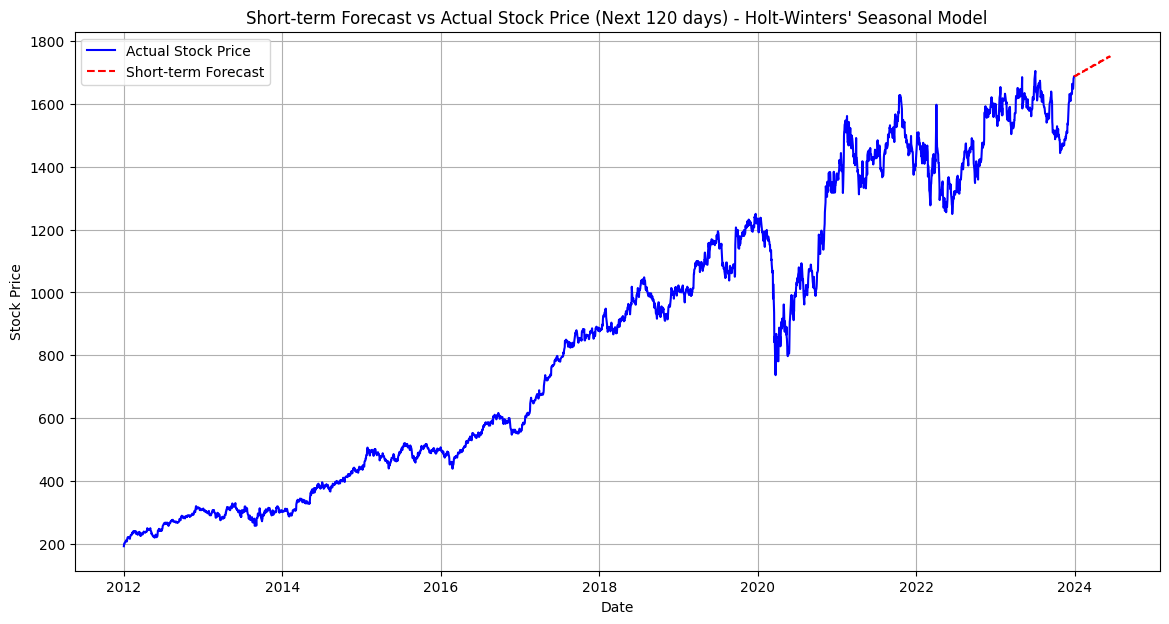

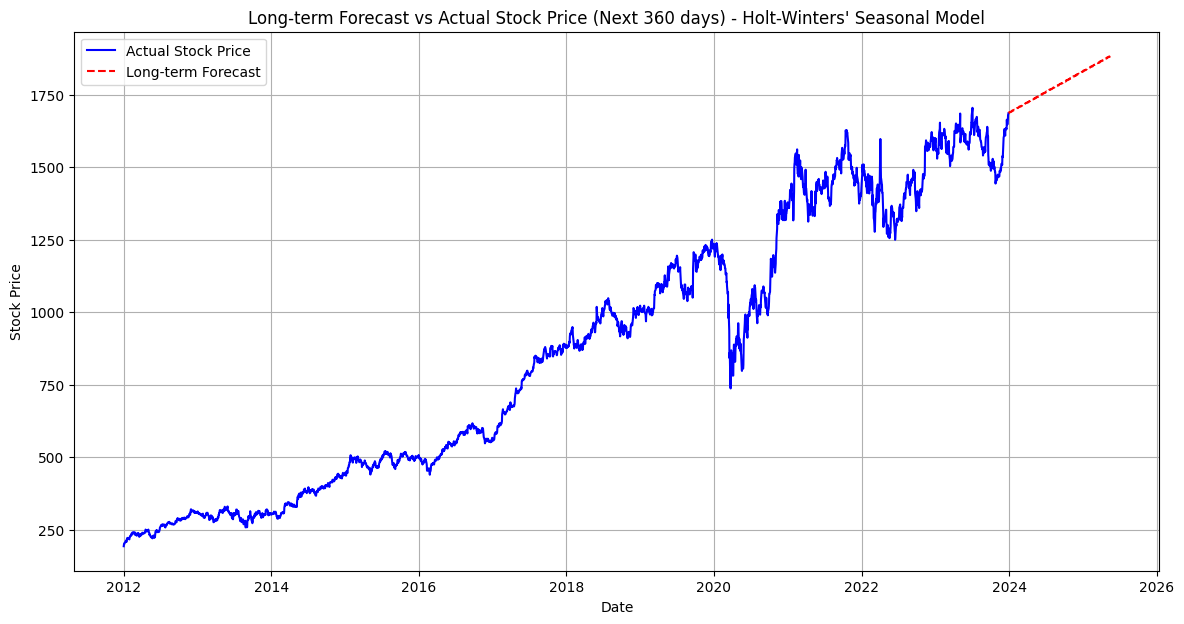

In [72]:
# Plotting short-term forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=120, freq='B'), short_term_forecast_hw, label='Short-term Forecast', color='red', linestyle='--')
plt.title('Short-term Forecast vs Actual Stock Price (Next 120 days) - Holt-Winters\' Seasonal Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Plotting long-term forecast vs actual
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['HDFCBANK'], label='Actual Stock Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=360, freq='B'), long_term_forecast_hw, label='Long-term Forecast', color='red', linestyle='--')
plt.title('Long-term Forecast vs Actual Stock Price (Next 360 days) - Holt-Winters\' Seasonal Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### **Combining forecast for all the three models**

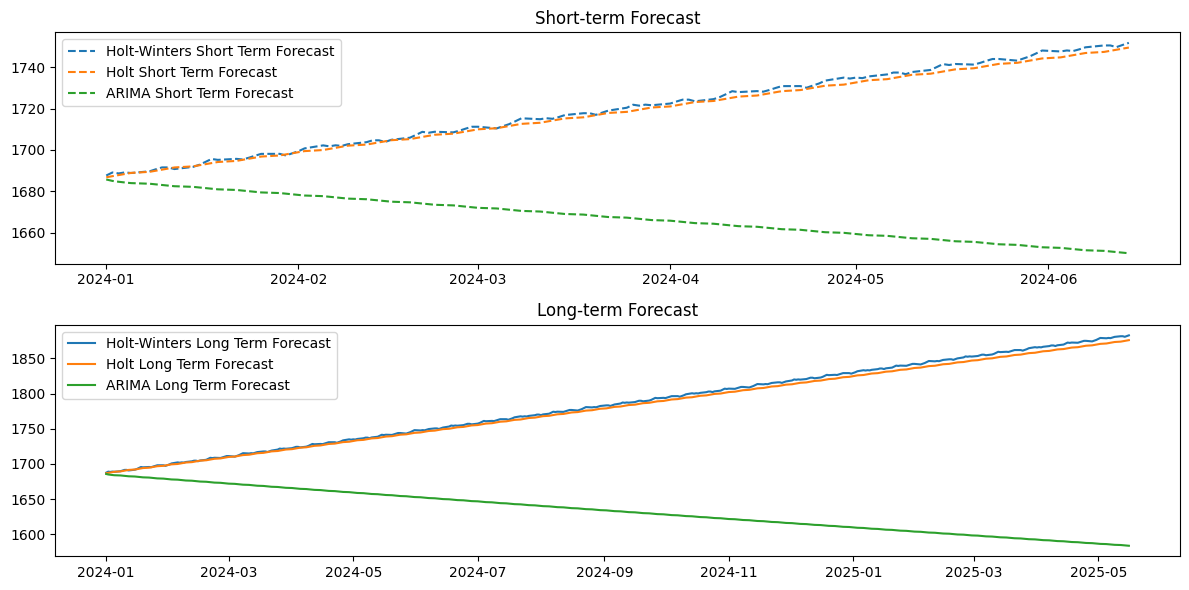

In [75]:
# Plotting Short-term Forecasts
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
plt.plot(short_term_forecast_hw, label='Holt-Winters Short Term Forecast', linestyle='--')
plt.plot(short_term_forecast_holt, label='Holt Short Term Forecast', linestyle='--')
plt.plot(short_term_forecast, label='ARIMA Short Term Forecast', linestyle='--')
plt.title('Short-term Forecast')
plt.legend()

# Plotting Long-term Forecasts
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
plt.plot(long_term_forecast_hw, label='Holt-Winters Long Term Forecast')
plt.plot(long_term_forecast_holt, label='Holt Long Term Forecast')
plt.plot(long_term_forecast, label='ARIMA Long Term Forecast')
plt.title('Long-term Forecast')
plt.legend()

plt.tight_layout()
plt.show()


## **Writing the short-term & Long-term forecast in csv file**

In [73]:
# Create DataFrame for Forecasts
forecasts = {
    'Date': pd.date_range(start=data.index[-1], periods=360, freq='B'),
    'Short-Term ARIMA': np.concatenate([short_term_forecast, [np.nan] * (360 - 120)]),
    'Long-Term ARIMA': long_term_forecast,
    'Short-Term Holt': np.concatenate([short_term_forecast_holt, [np.nan] * (360 - 120)]),
    'Long-Term Holt': long_term_forecast_holt,
    'Short-Term Holt-Winters': np.concatenate([short_term_forecast_hw, [np.nan] * (360 - 120)]),
    'Long-Term Holt-Winters': long_term_forecast_hw,
}

forecast_df = pd.DataFrame(forecasts)

# Create MAPE DataFrame
mape_data = {
    'Model': ['ARIMA', 'Holt', 'Holt-Winters'],
    'MAPE': [mape, mape_holt, mape_hw]
}
mape_df = pd.DataFrame(mape_data)

# Save to CSV
forecast_df.to_csv('forecasted_data.csv', index=False)
mape_df.to_csv('mape_scores.csv', index=False)

print("Forecast and MAPE scores have been saved to CSV files.")

Forecast and MAPE scores have been saved to CSV files.
